In [1]:
import cv2 # pip3 install opencv-python
import numpy as np
from matplotlib import pyplot as plt
from skimage.util.shape import view_as_windows
from PIL import Image, ImageDraw # pip4 install Pillow
import json
import os

In [3]:
rel_data_path = "../sample_data/"
test_name = "2020-03-11+15-04-20+NAB972-Seite+Rechts+Unten-_00053"

test_picture = np.array(Image.open(os.path.join(rel_data_path, test_name + ".jpg")))
with open(os.path.join(rel_data_path, test_name + ".json"), 'r') as f:
    test_labels = json.load(f)

In [35]:
view = lambda arr: Image.fromarray(arr).resize((200,200))

# How to find the step to use
First, let's simplify our problem by only considering the one dimensional case.
Second, let's define our problems's variables:
 - We've got a line of size $h$, you can think of it as the image's height, or width, or whatever
 - Then, we want to put $n$ windows on it.
 - These windows can overlap each other, let's call the size of that overlap between two isolated windows $o$
 - We have to consider the size $w$ of our windows (think $w$ for **w**indow, forget about width or it'll confuse you). 
   Each window has the same size.
 - Finally, we want to derive the distance between each window's centre, i.e. the step size $s$.
   
Now, let's look for a relation between all these quantities. They're all the same dimension (length along the a single axis) so we're good.
We'd have the following equations
$$
    h = n\cdot w - (n-1)\cdot o
$$

This comes simply from trying to find the height from all the other variables. Indeed, if the windows didn't overlap and just filled 100% of the height, we'd have $h=n\cdot w$. However, they *do* overlap, so we have to subtract the number of overlaps. Hopefully, the overlap is always the same, $o$, and since they only overlap two by two (meaning we never have 3 overlapping windows), we can say that we have $n-1$ distinct overlap regions.

We can deduct that $n-1$ overlap size from the total height the windows take, and that's how we come up with $h = n\cdot w - (n-1)\cdot o$.

But that's not really useful to know our image's height, we knew that already ! Thanksfully that's not the point. The point was to find a relation. This will hold no matter what algebra we apply to it. Rearranging to solve for $n$ will give us the number of windows if we know all the other variables:

$$
h = n\cdot w - (n-1)\cdot o
$$
$$
h = n(w-o) - o
$$
$$
n = \frac{h+o}{w-o}
$$

Now that we know the number of windows $n$, we just need to divide $h$ by $n+1$ to get $s$, i.e. the *step*.

$$
    s = \frac{h}{n+1} = \frac{h}{\frac{h+o}{w-o} + 1} = \frac{h}{\frac{h+o+w-o}{w-o}} = \frac{h(w-o)}{h+w}
$$

In [49]:
def find_step(height: int, window_size: int, overlap: int) -> int:
    """
    height: image's height, or width or whatever size you want to put the overlaping windows into
    window_size: the size of the windows, every window has the same size
    overlap: the size of the overlap between two windows
    
    You should have overlap < window_size < height !
    
    For the forumla detailed, see above.
    """
    assert overlap < window_size, "Windows can't overlap more than twice !"
    assert window_size < height, "Window size must be smaller than height !"
    return int(height * (window_size-overlap)/(height+window_size))

In [81]:
window_shape = (500, 500, 3)
overlap = 200
step = (
    find_step(test_picture.shape[0], 500, overlap),
    find_step(test_picture.shape[1], 500, overlap),
    1,
)

In [82]:
step

(257, 267, 1)

In [95]:
windows = view_as_windows(
    test_picture, 
    window_shape=window_shape, 
    step=step
)

In [96]:
windows.shape

(10, 14, 1, 500, 500, 3)

In [97]:
windows = np.squeeze(windows)

In [98]:
windows.shape

(10, 14, 500, 500, 3)

In [87]:
windows[0,0].shape

(500, 500, 3)

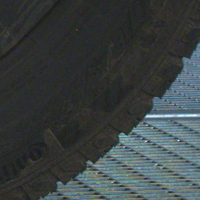

In [88]:
view(windows[-2,-1])

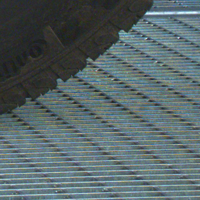

In [89]:
view(windows[-1,-1])


In [105]:
# Ratio number of pixel after windowing vs in the original picture
# this is also the ratio of memory usage between the two, were you to load all the windows in memory
np.prod(windows.shape[:-1])/np.prod(test_picture.shape[:-1])

2.8483072916666665

In [101]:
# Size in megabyte of that array
test_picture.size * test_picture.itemsize / 1e6

36.864

In [103]:
# Size in megabyte of that array
windows.size * windows.itemsize / 1e6

105.0

In [104]:
(windows.size * windows.itemsize)/(test_picture.size * test_picture.itemsize)

2.8483072916666665

In [116]:
test_pictures = np.concatenate((test_picture[np.newaxis, ...], 
                                test_picture[np.newaxis, ...], 
                                test_picture[np.newaxis, ...], 
                                test_picture[np.newaxis, ...], 
                                test_picture[np.newaxis, ...]), axis=0)

In [117]:
test_pictures.shape

(5, 3000, 4096, 3)

In [121]:
window_shape = (1, 500, 500, 3)
overlap = 200
double_step = (
    1,
    find_step(test_picture.shape[0], 500, overlap),
    find_step(test_picture.shape[1], 500, overlap),
    1,
)
double_windows = view_as_windows(test_pictures, window_shape, double_step)

In [122]:
double_windows.shape

(5, 10, 14, 1, 1, 500, 500, 3)

In [123]:
windows.shape

(10, 14, 500, 500, 3)